In [1]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
def read_file(file_name):
    file = open(file_name, "r")
    list_string = []
    i = 0
    while True:
        line = file.readline()
        list_string.append(line)
        if not line:
            break
        file.close
    return list_string

In [3]:
file_name = "Sim4MLX.dat"
main_data = []
list_string = read_file(file_name)
# last string is empty
list_string.pop()

''

In [4]:
# Parse data
param_data = []
signal_data = []
for string in list_string:
    data = np.fromstring(string, dtype=float, sep=' ')
    # Removing the row index at the beggining as it's redundant
    data = np.delete(data, 0)
    
    resistance_depth = data[:7]
    param_data.append(resistance_depth)

    # Up to 56 index, because value for 57 index is zero
    signal_values = np.log(data[7:56])
    signal_data.append(signal_values)

In [5]:
len(signal_data)

1000037

In [6]:
#Direct problem: by params predict signals

# Scale data
scaler = StandardScaler().fit(param_data)
param_data_scaled = scaler.transform(param_data)

# Split data into train and test
params_train, params_test, signal_train, signal_test = train_test_split(param_data_scaled, signal_data, 
                                                    train_size=0.67, 
                                                    random_state=42)

regr = linear_model.LinearRegression()

# Fit model
regr.fit(params_train, signal_train)

LinearRegression()

In [7]:
signal_pred = regr.predict(params_test)
print("Mean squared error: %.25f" % mean_squared_error(signal_test[0], signal_pred[0]))
print("Coefficient of determination: %.2f" % r2_score(signal_test, signal_pred))
# Result is 0.49 - not bad and not good, if take non-log signal
# Result is 0.59 - better, if take logarithmic signal

Mean squared error: 0.2309464399367011921970771
Coefficient of determination: 0.53


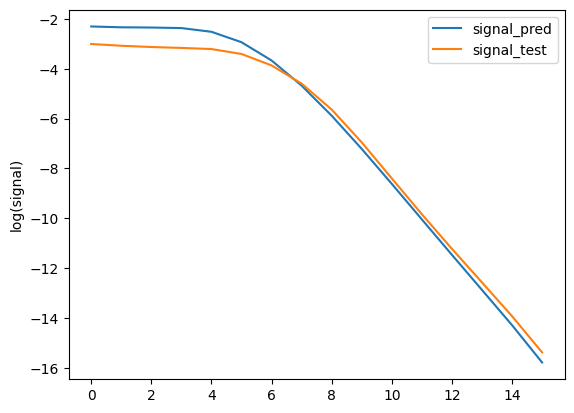

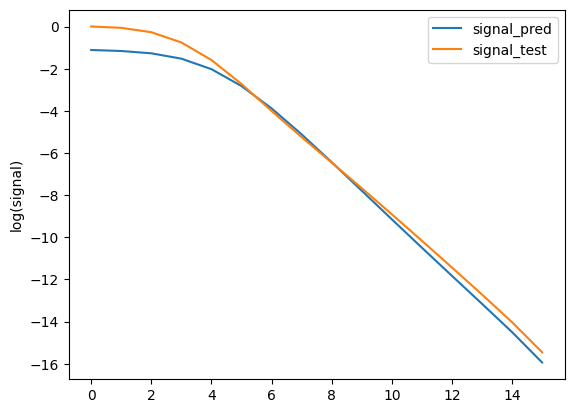

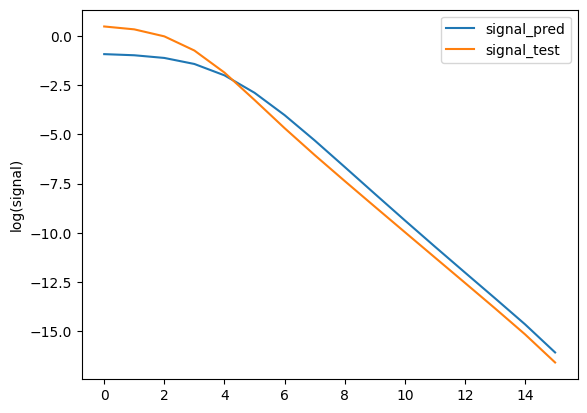

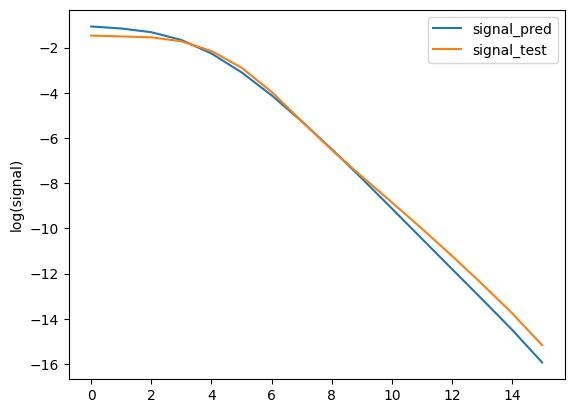

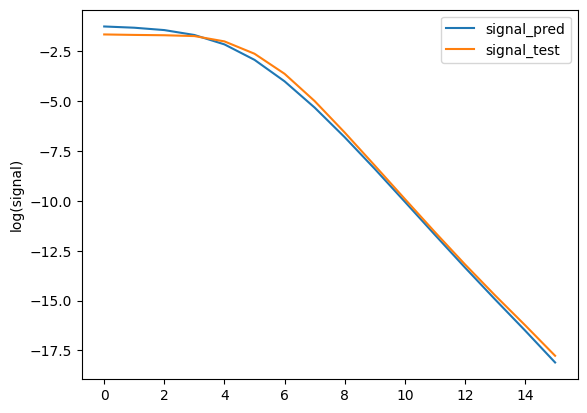

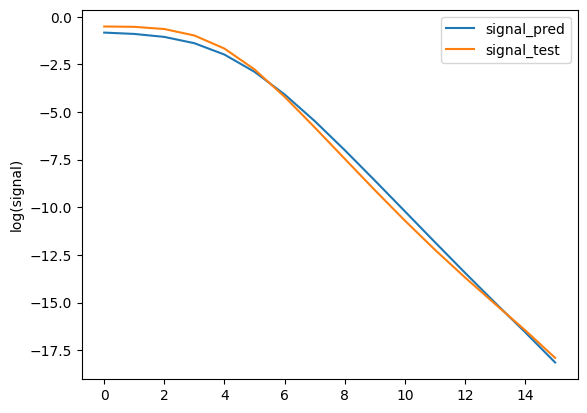

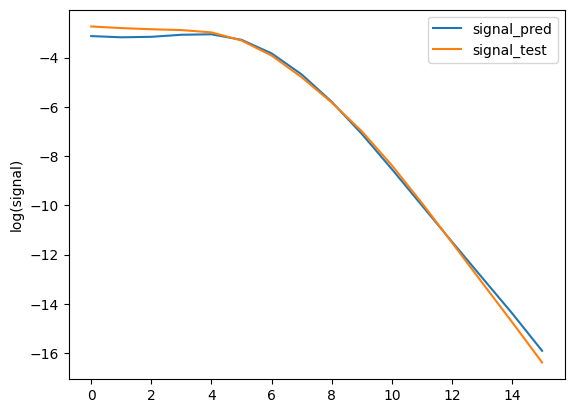

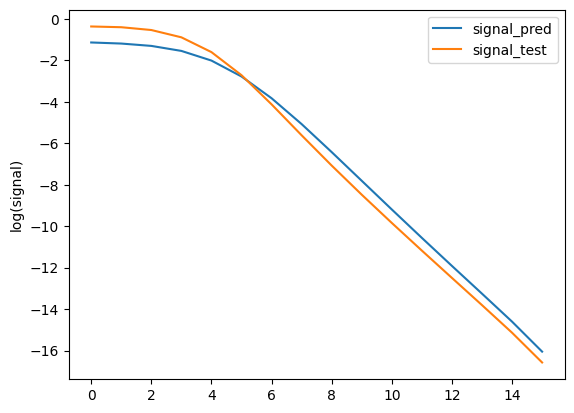

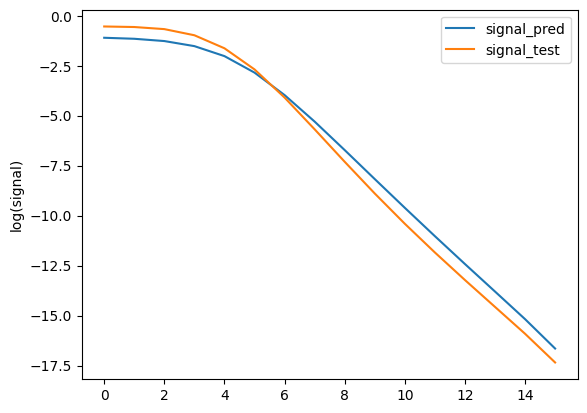

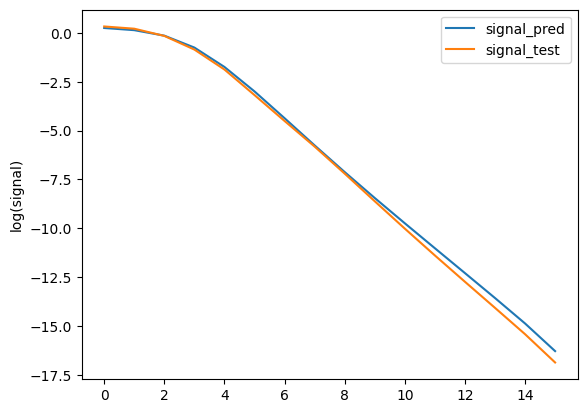

In [8]:
# Visualize 10 first pred and test signals
for i in range (10):
    plt.plot(signal_pred[i], label='signal_pred')
    plt.plot(signal_test[i], label='signal_test')
    plt.legend()
    plt.ylabel('log(signal)')
    plt.show()

In [9]:
# Inverse problem: by signal predict parameters

# Scale data
scaler = StandardScaler().fit(signal_data)
signal_data_scaled = scaler.transform(signal_data)

# Split data to train and test
signal_train, signal_test, params_train, params_test = train_test_split(signal_data_scaled, param_data, 
                                                    train_size=0.67, 
                                                    random_state=42)
regr = linear_model.LinearRegression()
# Fit model
regr.fit(signal_train, params_train)

LinearRegression()

In [10]:
params_pred = regr.predict(signal_test)
print("Mean squared error: %.25f" % mean_squared_error(params_test, params_pred))
print("Coefficient of determination: %.2f" % r2_score(params_test, params_pred))
## Coef is too low, linear regression is a bad choice

Mean squared error: 19679.7497772198912571184337139
Coefficient of determination: 0.26


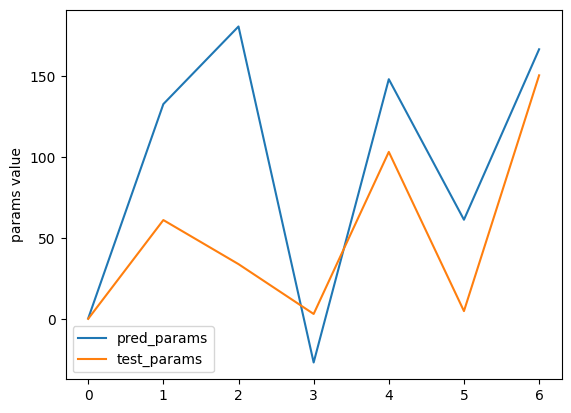

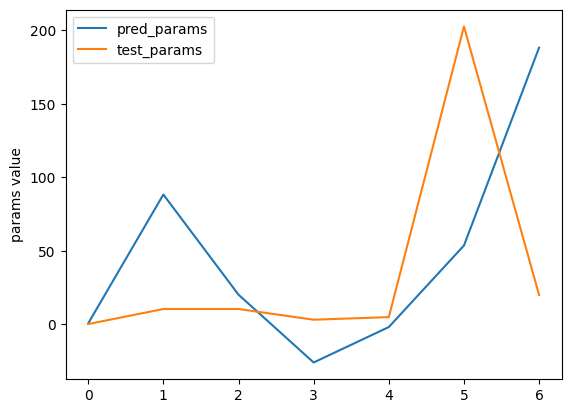

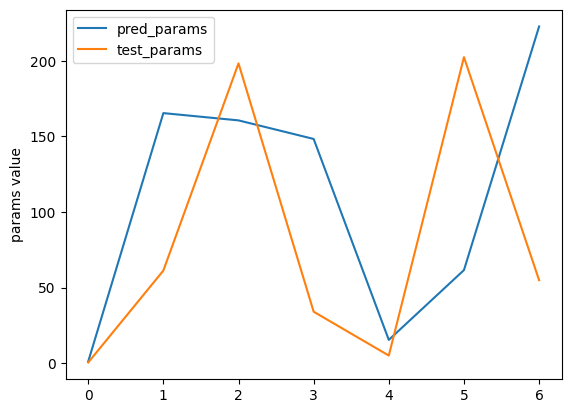

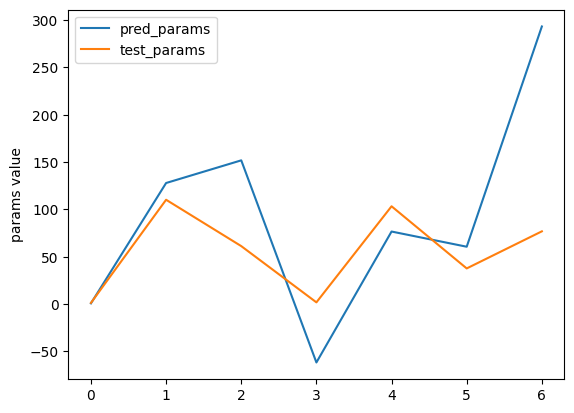

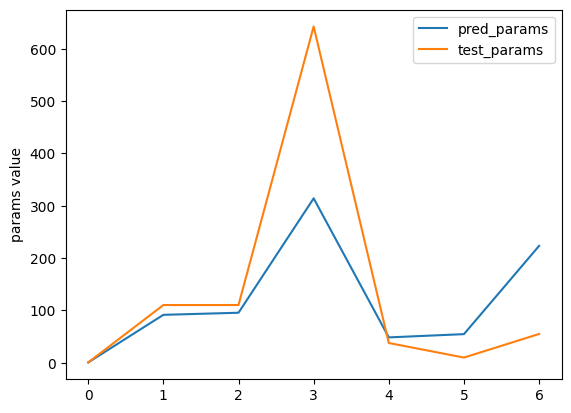

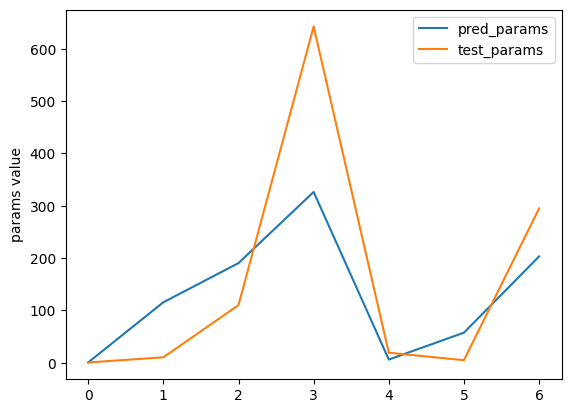

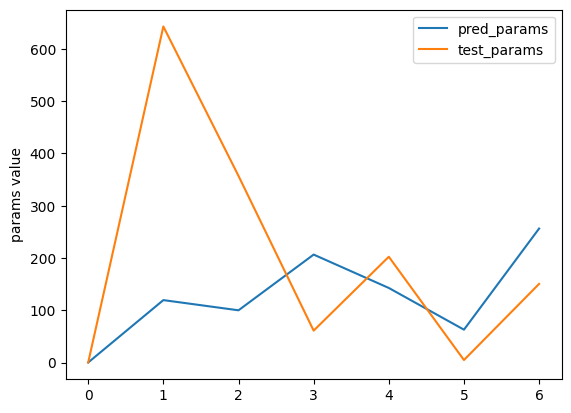

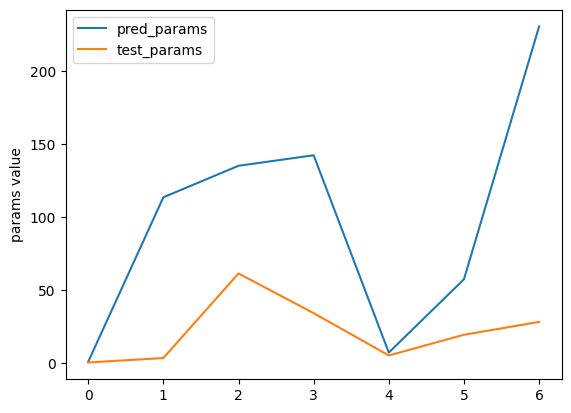

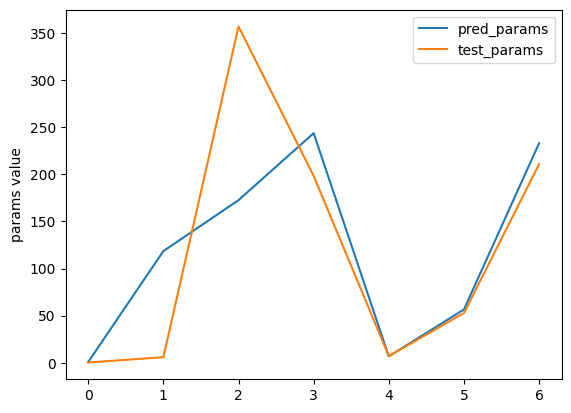

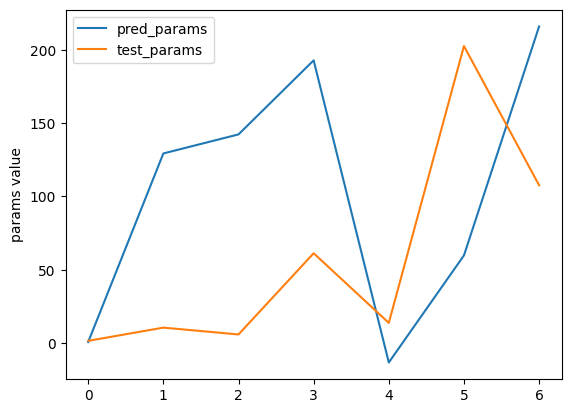

In [11]:
# Visualize 10 first pred and test params
for i in range (10):
    plt.plot(params_pred[i], label='pred_params')
    plt.plot(params_test[i], label='test_params')
    plt.legend()
    plt.ylabel('params value')
    plt.show()

In [12]:
# Вывод: для обратной задачи линейная регрессия плоха как с прологарифмированным, так и с обычным сигналом
# для прямой - если для обучения брать прологарифмированный сигнал, но на тесте линейная регрессия показывает
# результат лучше, чем если бы сигнал не был прологарифмирован

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [13]:


# Scale data
scaler = StandardScaler().fit(param_data)
param_data_scaled = scaler.transform(param_data)

# Split data into train and test
params_train, params_test, signal_train, signal_test = train_test_split(param_data_scaled, signal_data, 
                                                    train_size=0.75, 
                                                    random_state=42)

#regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
# не получается обучить на всем датасете, ядро отваливается, приходится делать батчами
# и запоминать результат с помощью warm_start=true
#regressor.fit(params_train, signal_train)


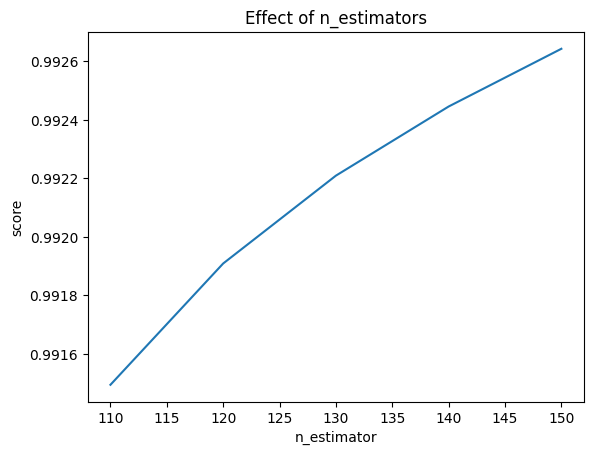

In [14]:
# warm_start = True is needed to 
# reuse the solution of the previous call to fit and add more estimators to the ensemble
regressor = RandomForestRegressor(n_estimators = 100, warm_start = True, n_jobs=-1,random_state=42)

scores = []
estimators = []

for params_train_split, signal_train_split in zip(np.array_split(params_train, 5), np.array_split(signal_train, 5)): # split into 500 dataframes 
    regressor.fit(params_train_split, signal_train_split)
    regressor.n_estimators += 10
    scores.append(regressor.score(params_test, signal_test))
    estimators.append(regressor.n_estimators)
    
    
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
    
    

In [15]:
signal_pred = regressor.predict(params_test)
print("Mean squared error: %.25f" % mean_squared_error(signal_test[0], signal_pred[0]))
print("Coefficient of determination: %.2f" % r2_score(signal_test, signal_pred))
print("Model score:  %.25f" %regressor.score(params_test, signal_test))
# Coefficient 0.99

Mean squared error: 0.0000270236262790669859641
Coefficient of determination: 0.99
Model score:  0.9926426366007906620936296


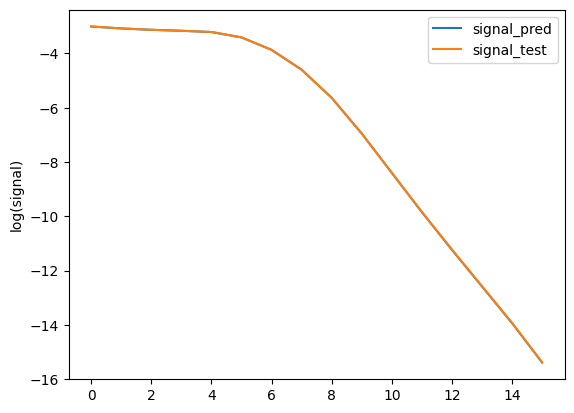

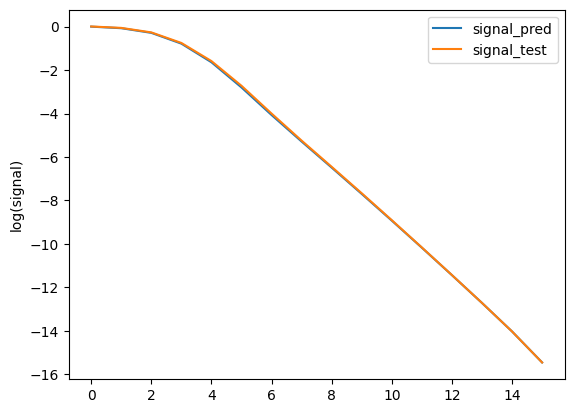

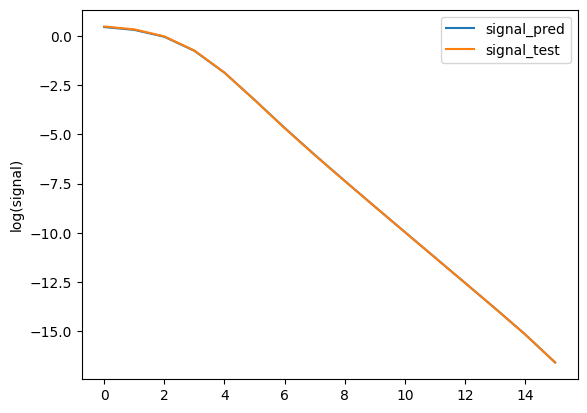

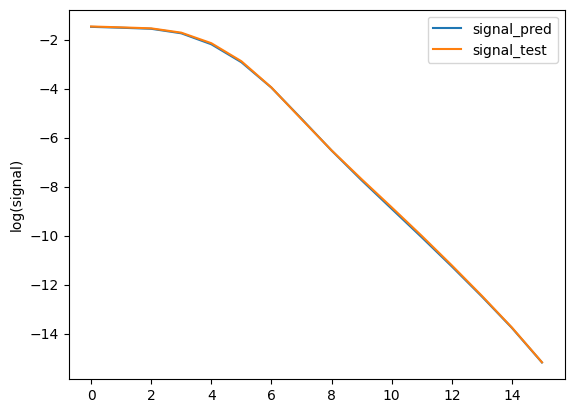

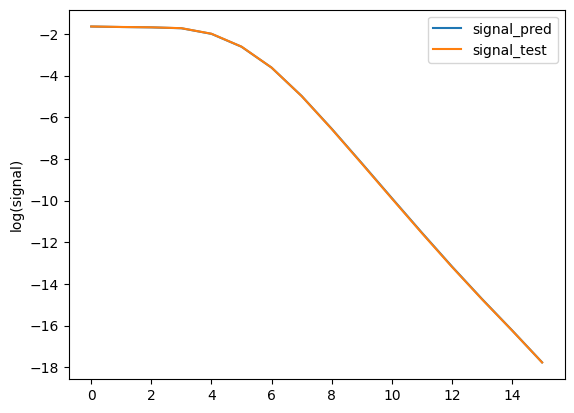

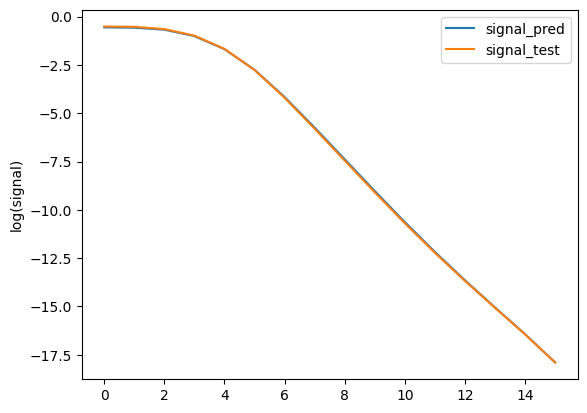

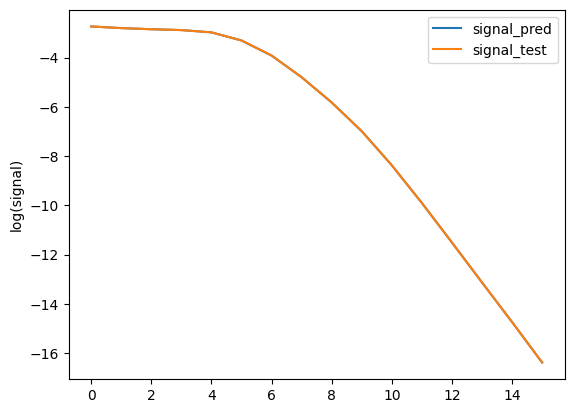

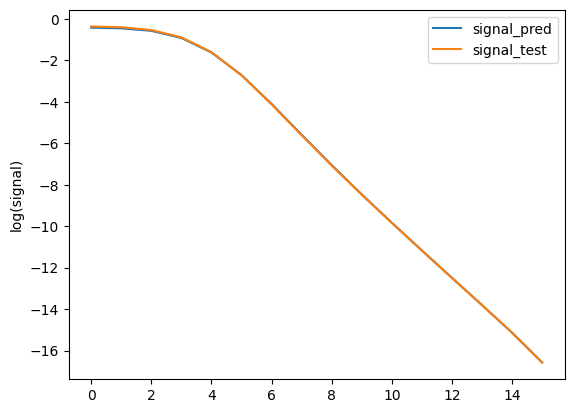

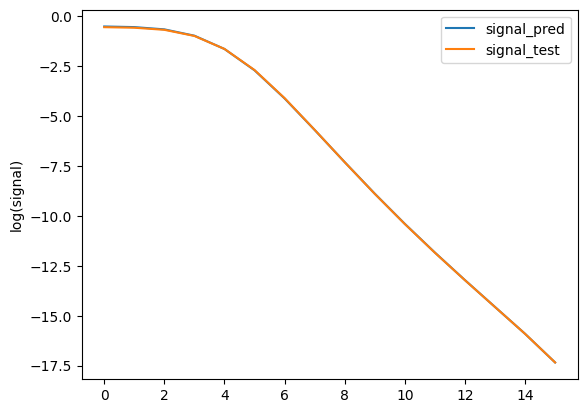

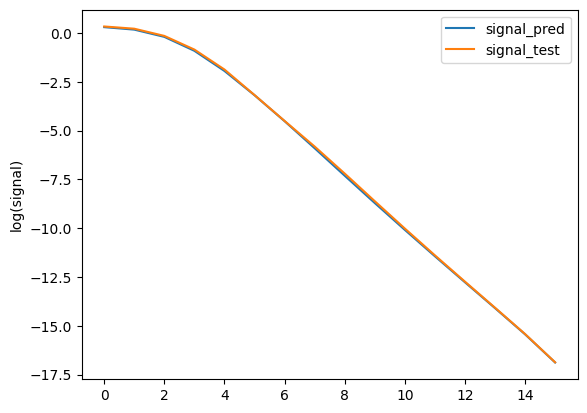

In [16]:
# Visualize 10 first pred and test signals
for i in range (10):
    plt.plot(signal_pred[i], label='signal_pred')
    plt.plot(signal_test[i], label='signal_test')
    plt.legend()
    plt.ylabel('log(signal)')
    plt.show()

In [10]:
# Inverse problem: by signal predict parameters
# Done in python script to prevent kernel death

In [12]:
params_pred = regressor.predict(signal_test)
print("Mean squared error: %.25f" % mean_squared_error(params_test, params_pred))
print("Coefficient of determination: %.2f" % r2_score(params_test, params_pred))
print("Model score:  %.25f" %regressor.score(signal_test, params_test))
# Можем улучшить коэффициент, если тестовая выборка будет больше,
# чем 0.1, но в колабе ограничения на озу не позволяют 

Mean squared error: 10270.9250615738892520312219858
Coefficient of determination: 0.61
Model score:  0.6134330224204862513914804


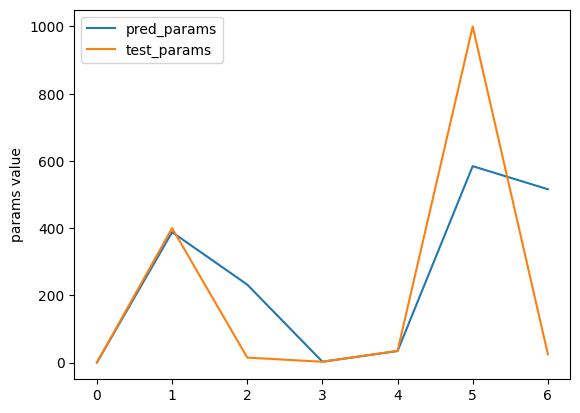

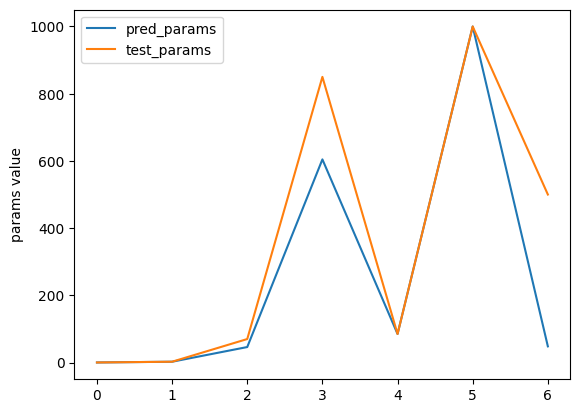

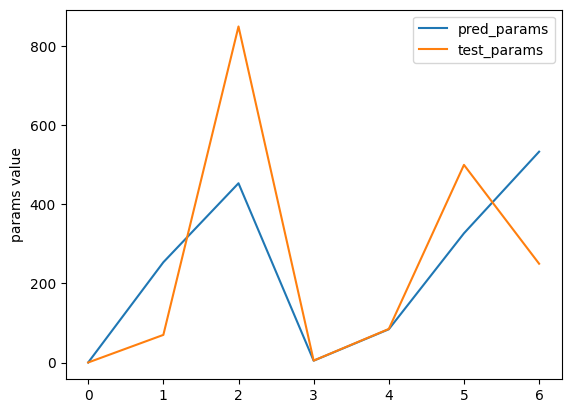

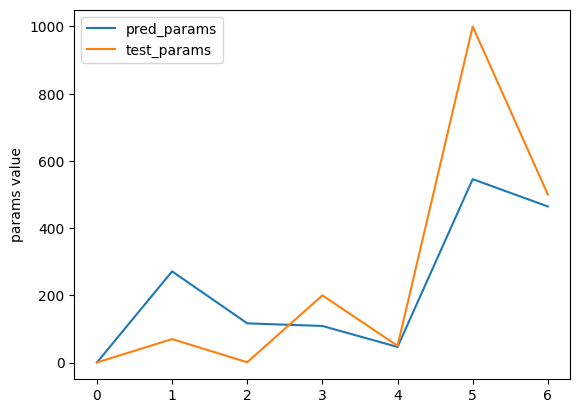

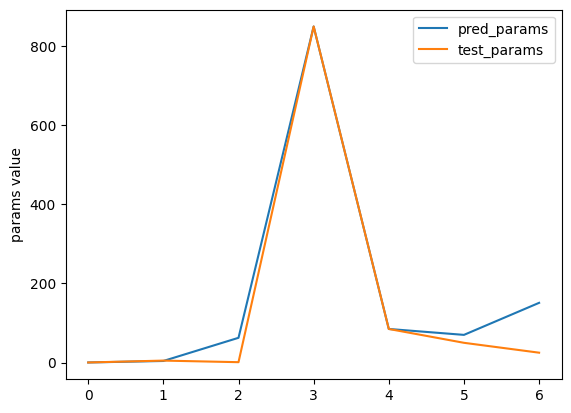

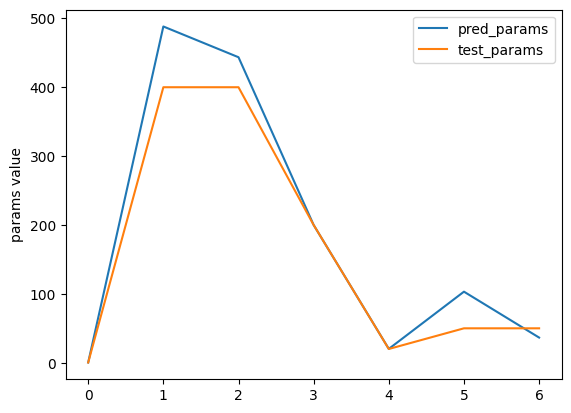

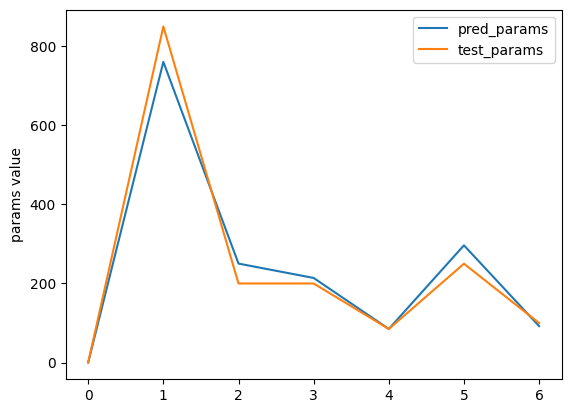

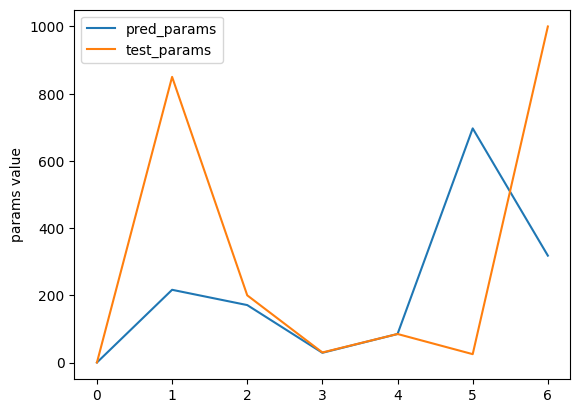

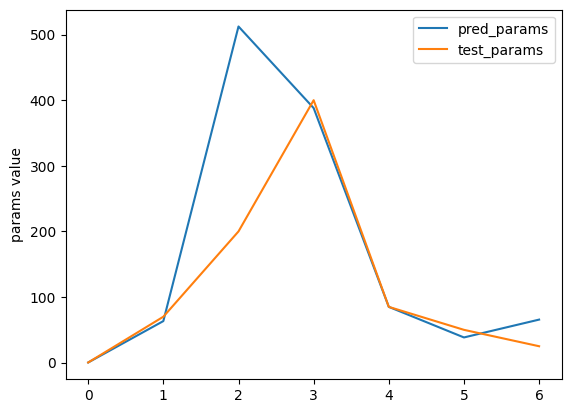

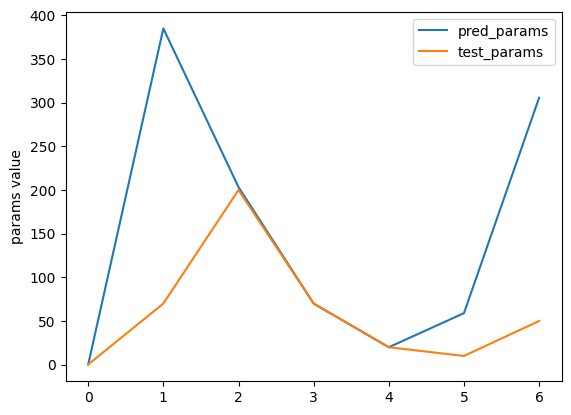

In [20]:
# Visualize 10 first pred and test params
for i in range (10):
    plt.plot(params_pred[i], label='pred_params')
    plt.plot(params_test[i], label='test_params')
    plt.legend()
    plt.ylabel('params value')
    plt.show()

In [13]:
import torch
import torch.nn as nn
print(torch.cuda.is_available())


True


In [7]:
device = torch.device('cuda')
device

device(type='cuda')

In [8]:
#Direct problem: by params predict signals
# Scale data
scaler = StandardScaler().fit(param_data)
param_data_scaled = scaler.transform(param_data)
# Split data into train and test
params_train, params_test, signal_train, signal_test = train_test_split(param_data_scaled, signal_data, 
                                                    train_size=0.67, 
                                                    random_state=42)


In [9]:
params_train_torch = torch.FloatTensor(params_train)
params_test_torch  = torch.FloatTensor(params_test).to(device)
signal_train_torch = torch.FloatTensor(signal_train)
signal_test_torch  = torch.FloatTensor(signal_test)

params_train_torch = params_train_torch.to(device)
params_test_torch  = params_test_torch.to(device)
signal_train_torch = signal_train_torch.to(device)
signal_test_torch  = signal_test_torch.to(device)



/tmp/ipykernel_470/3300712461.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  signal_train_torch = torch.FloatTensor(signal_train)


In [10]:
signal_test_torch.is_cuda

True

In [17]:
print(params_train_torch.size())
print(signal_train_torch.size())

n_input, n_hidden, n_out, batch_size, learning_rate = 7, 15, 49, 358996, 0.01

torch.Size([358996, 7])
torch.Size([358996, 49])


In [33]:
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
model.to(device)

Sequential(
  (0): Linear(in_features=7, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=15, bias=True)
  (3): ReLU()
  (4): Linear(in_features=15, out_features=49, bias=True)
  (5): Sigmoid()
)

In [34]:
print(model)

Sequential(
  (0): Linear(in_features=7, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=15, bias=True)
  (3): ReLU()
  (4): Linear(in_features=15, out_features=49, bias=True)
  (5): Sigmoid()
)


In [35]:
next(model.parameters()).is_cuda

True

In [36]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [37]:
losses = []
for epoch in range(5000):
    pred_signal_train = model(params_train_torch)
    loss = loss_function(pred_signal_train, signal_train_torch)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

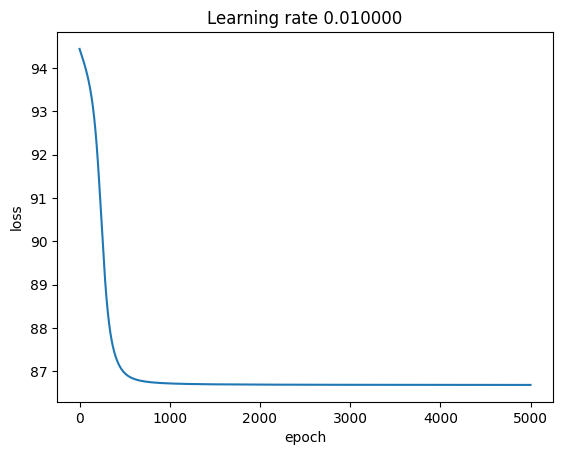

In [38]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()